# Notebook Modélisation

### Préparation du notebook

In [1]:
# Importer les librairies
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
! pip install yellowbrick

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
scaler = StandardScaler(copy=False)

In [4]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import  RandomForestRegressor

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import missingno as msno

In [6]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import ResidualsPlot, prediction_error

In [7]:
# Paramétrage visuelle de Scikit-Learn
sklearn.set_config(display="diagram")

### Définition des fonctions utilisées

In [8]:
# Fonction d'évaluation des modèles de régression
def reg_metrics(y_test, y_pred):
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmspe_cal = rmspe(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r_score = r2_score(y_test, y_pred)
    print("MAE: ",mae.round(3))
    print("MSE: ", mse.round(3))
    print("RMSE: ", rmse.round(3))
    print("RMSPE: ", rmspe_cal.round(3))
    print("MAPE: ", mape.round(3))
    print("R²: ", r_score.round(3))

In [69]:
# Fonction permettant de calculer le RMSPE: root mean square prediction error 

def rmspe(y_true, y_pred):
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true))))
    return loss


In [10]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) 

In [11]:
def evaluate(model, test_data, test_targets):
    predictions = model.predict(test_data)
    errors = abs(predictions - test_targets)
    mae = 100 * np.mean(errors / test_targets)
    accuracy = 100 - mae
    print('Model Performance')
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [12]:
# fonction pour créer un feature importance dataframe
def feature_importance(column_names, importances):
    df = pd.DataFrame({'feature': column_names,'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df

In [13]:
# fonction pour créer un plot de feature importance dataframe (horizontal barchart)
def feature_importance_plot(feature_importance_df, title):
    feature_importance_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = feature_importance_df.head(8), orient = 'h', color = 'royalblue').set_title(title, fontsize = 20)

## Chargement du fichier

In [14]:
#chargement du fichier
data=pd.read_csv("export_dataF5-P4.csv",encoding="utf-8")
data.shape

(3279, 14)

In [15]:
data['Parking'] = data['Parking'].replace(np.nan, 0)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PrimaryPropertyType           3279 non-null   object 
 1   CouncilDistrictCode           3279 non-null   int64  
 2   NumberofBuildings             3279 non-null   float64
 3   NumberofFloors                3279 non-null   float64
 4   PropertyGFATotal              3279 non-null   int64  
 5   ENERGYSTARScore               2199 non-null   float64
 6   SiteEnergyUse(kBtu)           3279 non-null   float64
 7   GHGEmissions(MetricTonsCO2e)  3279 non-null   float64
 8   Ancienneté                    3279 non-null   int64  
 9   ElectricityProportion         3279 non-null   float64
 10  SteamUseProportion            3279 non-null   float64
 11  WN                            3279 non-null   float64
 12  Parking                       3279 non-null   float64
 13  Nat

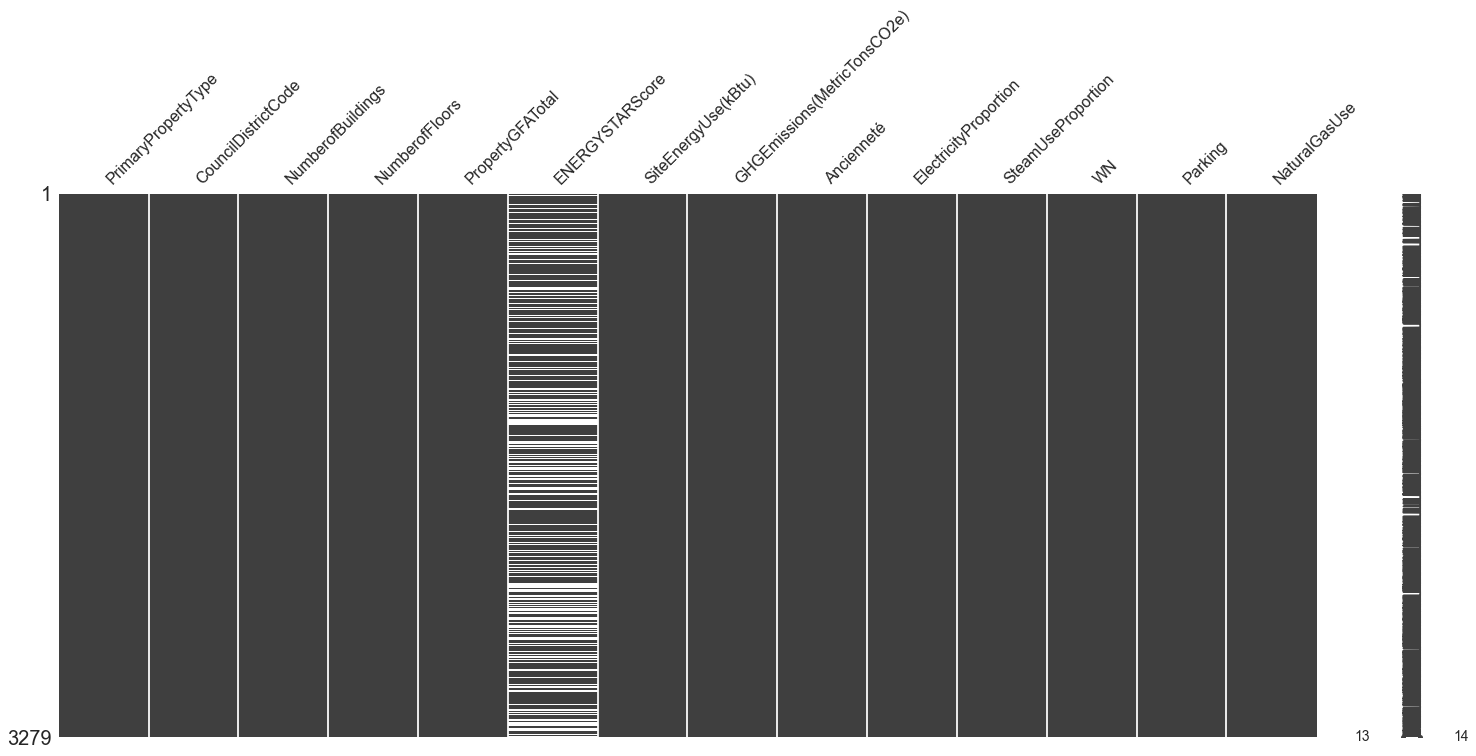

In [17]:
msno.matrix(data);

#### On sait désormais que notre fichier ne contient plus de NaN (excepté pour la variable EnergyStar mais on ne va pas l'utiliser pour l'instant) 

#### On applique une transformation logarithmique sur nos deux variables cibles car elles ne suivent pas une loi normale

In [18]:
data["SiteEnergyUse(kBtu)_log"] = np.log(data["SiteEnergyUse(kBtu)"])
data["GHGEmissions(MetricTonsCO2e)_log"] = np.log(data["GHGEmissions(MetricTonsCO2e)"])

# 1-Prédiction de la consommation d'énergie

#### Sélection de notre variable cible "y"

In [19]:
y=data["SiteEnergyUse(kBtu)_log"]

In [20]:
to_categorical = data[["PrimaryPropertyType","CouncilDistrictCode","Parking","NaturalGasUse"]]
list(to_categorical)

['PrimaryPropertyType', 'CouncilDistrictCode', 'Parking', 'NaturalGasUse']

#### Sélection des variables de nos features X qui seront:
- 1/PrimaryPropertyType
- 2/CouncilDistrictCode
- 3/Parking
- 4/NaturalGasUse
- 5/NumberofBuildings
- 6/NumberofFloors
- 7/Ancienneté
- 8/ElectricityProportion
- 9/SteamUseProportion
- 10/WN

In [21]:
X=data.drop(['ENERGYSTARScore','SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)','SiteEnergyUse(kBtu)_log', 'GHGEmissions(MetricTonsCO2e)_log'], axis=1)

#### Encodage des variables catégorielles

In [22]:
X= pd.get_dummies(data=X, columns=list(to_categorical))

In [23]:
X

,NumberofBuildings,NumberofFloors,PropertyGFATotal,Ancienneté,ElectricityProportion,SteamUseProportion,WN,PrimaryPropertyType_College/University,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Distribution Center\n,...,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,Parking_0.0,Parking_1.0,NaturalGasUse_0,NaturalGasUse_1
0,1.0,12.0,88434,88,0.527995,0.289773,1.016631,0,0,0,...,0,0,0,0,0,1,1,0,0,1
1,1.0,11.0,103566,19,0.467477,0.000000,1.049263,0,0,0,...,0,0,0,0,0,1,0,1,0,1
2,1.0,41.0,961990,46,0.680459,0.268839,1.032485,0,0,0,...,0,0,0,0,0,1,1,0,0,1
3,1.0,10.0,61320,89,0.098090,0.830998,1.004751,0,0,0,...,0,0,0,0,0,1,1,0,0,1
4,1.0,18.0,119890,35,0.409077,0.000000,1.016801,0,0,0,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,1.0,1.0,12294,26,0.616974,0.000000,1.109748,0,0,0,...,1,0,0,0,0,0,1,0,0,1
3275,1.0,1.0,16000,12,0.417296,0.000000,1.108842,0,0,0,...,1,0,0,0,0,0,1,0,0,1
3276,1.0,1.0,13157,42,0.310820,0.000000,1.049926,0,0,0,...,0,0,0,0,0,1,1,0,0,1
3277,1.0,1.0,14101,27,0.484898,0.000000,1.088079,0,0,0,...,0,0,0,0,0,0,1,0,0,1


#### Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set) avec un test size de 20%

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [25]:
X_train

,NumberofBuildings,NumberofFloors,PropertyGFATotal,Ancienneté,ElectricityProportion,SteamUseProportion,WN,PrimaryPropertyType_College/University,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Distribution Center\n,...,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,Parking_0.0,Parking_1.0,NaturalGasUse_0,NaturalGasUse_1
601,1.0,2.0,123000,49,1.000042,0.0,1.000000,0,0,0,...,1,0,0,0,0,0,1,0,1,0
3217,0.0,8.0,339591,3,0.585426,0.0,1.030299,0,0,0,...,0,0,0,0,0,1,0,1,0,1
98,1.0,4.0,162222,19,0.569570,0.0,1.000000,0,0,0,...,0,0,0,0,0,1,0,1,0,1
977,1.0,1.0,33005,40,0.676995,0.0,1.052227,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1043,1.0,2.0,27574,33,1.000041,0.0,1.016815,0,0,0,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,1.0,3.0,40067,29,1.000042,0.0,1.000000,0,0,0,...,0,0,0,0,0,1,1,0,1,0
3264,1.0,1.0,11685,3,0.408069,0.0,1.138755,0,0,0,...,0,1,0,0,0,0,1,0,0,1
1653,1.0,28.0,416281,33,0.632519,0.0,1.023696,0,0,0,...,0,0,0,0,0,1,0,1,0,1
2607,1.0,2.0,56193,58,0.744192,0.0,1.032873,0,0,0,...,1,0,0,0,0,0,1,0,0,1


#### Normalisation des variables numériques 

In [26]:
numeric_columns = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ancienneté',
    'ElectricityProportion','SteamUseProportion','WN']
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns],y_train)

<ipython-input-26-9ff3f63ac490>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns],y_train)
C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


#### utiliser les paramètres du train set pour normaliser l'e test set. Le modèle ne devrait pas avoir d'informations sur le train set

In [27]:
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

<ipython-input-27-b60456c427f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])
C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [28]:
X_test

,NumberofBuildings,NumberofFloors,PropertyGFATotal,Ancienneté,ElectricityProportion,SteamUseProportion,WN,PrimaryPropertyType_College/University,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Distribution Center\n,...,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,Parking_0.0,Parking_1.0,NaturalGasUse_0,NaturalGasUse_1
3021,-0.071907,-0.481095,-0.429023,0.453553,-0.196686,-0.224921,0.526261,0,0,0,...,1,0,0,0,0,0,1,0,0,1
499,-0.071907,-0.481095,-0.034771,-0.516814,0.390734,-0.224921,-0.223419,0,0,0,...,0,0,0,0,0,1,1,0,0,1
2456,-0.071907,-0.172627,-0.450568,-0.820053,1.151118,-0.224921,-0.605848,0,0,0,...,0,0,0,0,0,1,0,1,1,0
501,-0.071907,-0.481095,-0.322464,-0.516814,0.120397,-0.224921,-0.849636,0,0,0,...,0,0,0,0,0,1,1,0,0,1
1256,-0.071907,-0.481095,-0.396232,0.059342,-0.764656,-0.224921,1.954771,0,0,0,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,-0.071907,-0.481095,0.278801,-1.153617,0.276952,-0.224921,-0.128400,0,0,0,...,0,0,0,0,1,0,1,0,0,1
2639,-0.071907,-0.018393,-0.468467,1.848455,1.151116,-0.224921,-0.150978,0,0,0,...,0,0,0,0,1,0,1,0,1,0
1627,-0.071907,-0.172627,1.673460,1.090356,-0.412926,3.894009,0.251182,1,0,0,...,0,1,0,0,0,0,1,0,0,1
2560,-0.071907,-0.481095,-0.434921,-0.456166,1.151120,-0.224921,-0.338905,0,0,0,...,1,0,0,0,0,0,1,0,1,0


### Mise en oeuvre de plusieurs modèles d'apprentissage et d'une baseline Dummy Regressor

In [29]:
# instanciation des différents modèles de régression
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [30]:
dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
ridge = Ridge(random_state=0)
lasso = Lasso(random_state=0)
svm_reg = SVR()
rdmforest = RandomForestRegressor(random_state=0)

In [31]:
model = [dummy_reg, lin_reg, ridge, lasso,  svm_reg,   rdmforest]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse= np.sqrt (mean_squared_error (y_test,y_pred))
    r_score = r2_score(y_test, y_pred).round(3)
    dict_model[model] = ( mae.round(3), mse.round(3),rmse.round(3), r_score)

eval_model = pd.DataFrame(dict_model, index=[ "MAE","MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "Ridge", "Lasso",  "SVM",  "Random Forest"]

eval_model

,Dummy Regressor,Linear Regression,Ridge,Lasso,SVM,Random Forest
MAE,1.030,0.658,0.659,1.036,0.482,0.400
MSE,1.712,0.736,0.735,1.691,0.467,0.321
RMSE,1.308,0.858,0.858,1.301,0.683,0.567
R²,-0.012,0.565,0.565,-0.000,0.724,0.810


- On remarque d'abord que nos modèles sont plus performants que le modèle de base "Dummy Regressor" (excepté le Lasso)
- Les modèles linéaires ne présentent pas de très hautes performances celà est du à la non linéarité de notre problème
- Les meilleures performances sont celles du modèle "Random Forest" 

Modèle à Optimiser: 
- "Random Forest" 

### Random forest - GridSearchCV

In [32]:
parameters = {
    'n_estimators' : [10,50,100,300,500,700], #nombre d'arbres de décision
    'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}

RandomForestmodel_search = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=0),
                               param_grid = parameters,
                              verbose=2,
                               cv=5)

RandomForestmodel_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   2.7s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   0.1s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   0.1s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   0.1s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   0.1s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   0.3s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   0.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   0.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   0.5s
[CV] max_features=auto, min_samples_leaf=1

[CV]  max_features=auto, min_samples_leaf=3, n_estimators=700, total=   3.5s
[CV] max_features=auto, min_samples_leaf=3, n_estimators=700 .........
[CV]  max_features=auto, min_samples_leaf=3, n_estimators=700, total=   3.2s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=10, total=   0.1s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=10, total=   0.1s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=10, total=   0.1s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=10, total=   0.1s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=10, total=   0.1s
[CV] max_features=auto, min_samples_leaf

[CV]  max_features=auto, min_samples_leaf=10, n_estimators=500, total=   1.7s
[CV] max_features=auto, min_samples_leaf=10, n_estimators=700 ........
[CV]  max_features=auto, min_samples_leaf=10, n_estimators=700, total=   2.6s
[CV] max_features=auto, min_samples_leaf=10, n_estimators=700 ........
[CV]  max_features=auto, min_samples_leaf=10, n_estimators=700, total=   2.4s
[CV] max_features=auto, min_samples_leaf=10, n_estimators=700 ........
[CV]  max_features=auto, min_samples_leaf=10, n_estimators=700, total=   2.5s
[CV] max_features=auto, min_samples_leaf=10, n_estimators=700 ........
[CV]  max_features=auto, min_samples_leaf=10, n_estimators=700, total=   2.4s
[CV] max_features=auto, min_samples_leaf=10, n_estimators=700 ........
[CV]  max_features=auto, min_samples_leaf=10, n_estimators=700, total=   2.6s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=10 ..........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=10, total=   0.0s
[CV] max_features=sqrt, min_sa

[CV]  max_features=sqrt, min_samples_leaf=3, n_estimators=500, total=   1.0s
[CV] max_features=sqrt, min_samples_leaf=3, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=3, n_estimators=500, total=   1.0s
[CV] max_features=sqrt, min_samples_leaf=3, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=3, n_estimators=500, total=   1.0s
[CV] max_features=sqrt, min_samples_leaf=3, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=3, n_estimators=500, total=   1.1s
[CV] max_features=sqrt, min_samples_leaf=3, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=3, n_estimators=500, total=   1.0s
[CV] max_features=sqrt, min_samples_leaf=3, n_estimators=700 .........
[CV]  max_features=sqrt, min_samples_leaf=3, n_estimators=700, total=   1.6s
[CV] max_features=sqrt, min_samples_leaf=3, n_estimators=700 .........
[CV]  max_features=sqrt, min_samples_leaf=3, n_estimators=700, total=   1.4s
[CV] max_features=sqrt, min_samples

[CV]  max_features=sqrt, min_samples_leaf=10, n_estimators=300, total=   0.7s
[CV] max_features=sqrt, min_samples_leaf=10, n_estimators=300 ........
[CV]  max_features=sqrt, min_samples_leaf=10, n_estimators=300, total=   0.6s
[CV] max_features=sqrt, min_samples_leaf=10, n_estimators=300 ........
[CV]  max_features=sqrt, min_samples_leaf=10, n_estimators=300, total=   0.5s
[CV] max_features=sqrt, min_samples_leaf=10, n_estimators=300 ........
[CV]  max_features=sqrt, min_samples_leaf=10, n_estimators=300, total=   0.5s
[CV] max_features=sqrt, min_samples_leaf=10, n_estimators=500 ........
[CV]  max_features=sqrt, min_samples_leaf=10, n_estimators=500, total=   0.8s
[CV] max_features=sqrt, min_samples_leaf=10, n_estimators=500 ........
[CV]  max_features=sqrt, min_samples_leaf=10, n_estimators=500, total=   0.8s
[CV] max_features=sqrt, min_samples_leaf=10, n_estimators=500 ........
[CV]  max_features=sqrt, min_samples_leaf=10, n_estimators=500, total=   0.9s
[CV] max_features=sqrt, min_

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  4.3min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500, 700]},
             verbose=2)

In [33]:
# Visualisation des meilleurs paramètres
RandomForestmodel_search.best_params_

{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 700}

In [34]:
RandomForestmodel_search.best_estimator_

RandomForestRegressor(n_estimators=700, n_jobs=-1, random_state=0)

In [35]:
# Attribution du modèle entraîné à une variable
final_model_Energy = RandomForestmodel_search.best_estimator_

In [36]:
final_predictions_Energy = final_model_Energy.predict(X_test)

In [37]:
reg_metrics(np.array(y_test), final_predictions_Energy)

MAE:  0.399
MSE:  0.32
RMSE:  0.566
RMSPE:  0.041
MAPE:  0.028
R²:  0.811


- L'évaluation finale de notre modèle montre des scores plutôt bons. Notre modèle estime la consommation d'énergie avec une erreur (RMSPE)de plus ou moins 0.4%. Il a un coefficient de détermination de 81%, c'est-à-dire qu'il permet d'expliquer 81% de la variance observée dans nos variables cibles. De plus, l'erreur moyenne est de 0.028% (MAPE).

In [70]:
best_random = RandomForestmodel_search.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.3381
Accuracy = 85.73%.


In [71]:
base_importance = feature_importance(X_train.columns, best_random.feature_importances_)
base_importance

,feature,feature_importance
0,PropertyGFATotal,0.466720
1,ElectricityProportion,0.345788
2,WN,0.036367
3,Ancienneté,0.030027
4,NumberofFloors,0.022862
5,PrimaryPropertyType_Non-Refrigerated Warehouse,0.012589
6,PrimaryPropertyType_Warehouse,0.010311
7,PrimaryPropertyType_Supermarket / Grocery Store,0.007848
8,PrimaryPropertyType_Supermarket/Grocery Store,0.007667
9,CouncilDistrictCode_2,0.005724


In [41]:
coefficients = abs(RandomForestmodel_search.best_estimator_.feature_importances_)
df_coefficients = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

### Feature Importance

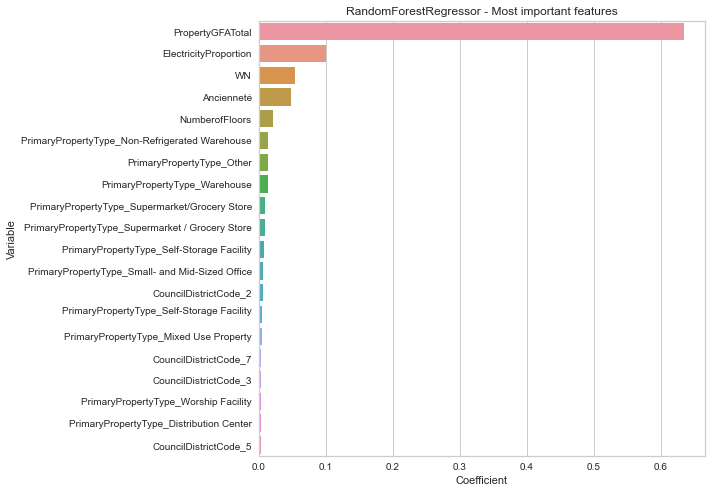

In [42]:
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Most important features')
sns.barplot(y = df_coefficients['Variable'].head(20), x = df_coefficients['Coefficient'].head(20))
plt.show()

### Analyse des résidus

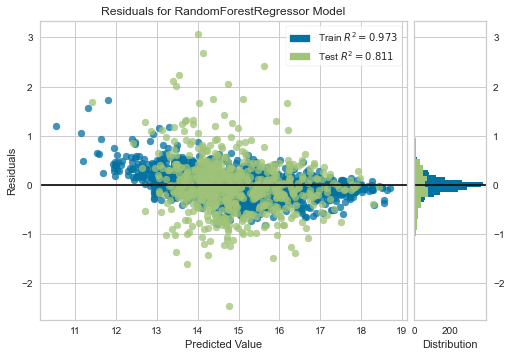

In [43]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(best_random, X_train, y_train, X_test, y_test)

- Les distributions des résidus du jeu d'entraînement et du jeu de test semblent suivre une loi normale. La distribution des résidus du jeu de test est plus aplatie. Cela peut s'expliquer par le nombre de données moins importants (seulement 20% de l'échantillon).

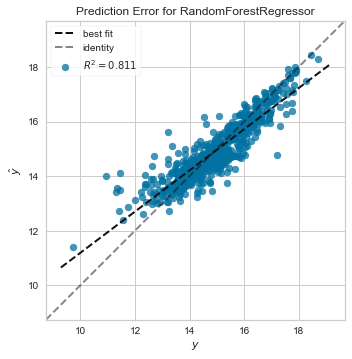

In [44]:
visualizer = prediction_error(best_random, X_train, y_train, X_test, y_test)

# 2-Prédiction des emissions de CO2 sans l"EnergyStarscore"

### On commence d’abord par supprimer les bâtiments dont on ne connait pas l’energy star score soit environ le tier de notre dataset, on veut évaluer l’intérêt de cette variable et son imputation causera inévitablement des erreurs! 

In [46]:
data2= data[(data['ENERGYSTARScore'].notna())]
data2.shape

(2199, 16)

##### Sélection de notre variable cible "y=GHGEmissions(MetricTonsCO2e)_log" 

In [47]:
y=data2["GHGEmissions(MetricTonsCO2e)_log"]

In [48]:
to_categorical = data2[["PrimaryPropertyType","CouncilDistrictCode","Parking","NaturalGasUse"]]
list(to_categorical)

['PrimaryPropertyType', 'CouncilDistrictCode', 'Parking', 'NaturalGasUse']

#### Sélection des variables de nos features X qui seront:
- 1/PrimaryPropertyType
- 2/CouncilDistrictCode
- 3/Parking
- 4/NaturalGasUse
- 5/NumberofBuildings
- 6/NumberofFloors
- 7/Ancienneté
- 8/ElectricityProportion
- 9/SteamUseProportion
- 10/WN

In [49]:
X=data2.drop(['ENERGYSTARScore','SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)','SiteEnergyUse(kBtu)_log', 'GHGEmissions(MetricTonsCO2e)_log'], axis=1)

##### Encodage des variables catégorielles

In [50]:
X= pd.get_dummies(data=X, columns=list(to_categorical))

#### Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set) avec un test size de 20%

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [52]:
X

,NumberofBuildings,NumberofFloors,PropertyGFATotal,Ancienneté,ElectricityProportion,SteamUseProportion,WN,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Distribution Center\n,PrimaryPropertyType_Hospital,...,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,Parking_0.0,Parking_1.0,NaturalGasUse_0,NaturalGasUse_1
0,1.0,12.0,88434,88,0.527995,0.289773,1.016631,0,0,0,...,0,0,0,0,0,1,1,0,0,1
1,1.0,11.0,103566,19,0.467477,0.000000,1.049263,0,0,0,...,0,0,0,0,0,1,0,1,0,1
2,1.0,41.0,961990,46,0.680459,0.268839,1.032485,0,0,0,...,0,0,0,0,0,1,1,0,0,1
3,1.0,10.0,61320,89,0.098090,0.830998,1.004751,0,0,0,...,0,0,0,0,0,1,1,0,0,1
4,1.0,18.0,119890,35,0.409077,0.000000,1.016801,0,0,0,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,1.0,2.0,24990,87,0.490206,0.000000,1.070389,0,0,0,...,1,0,0,0,0,0,1,0,0,1
3260,1.0,3.0,45000,1,1.000000,0.000000,1.054126,0,0,0,...,0,1,0,0,0,0,1,0,1,0
3269,1.0,1.0,13661,64,1.000000,0.000000,1.111122,0,0,0,...,0,0,0,0,0,1,1,0,1,0
3272,1.0,1.0,15398,56,0.715652,0.000000,1.067978,0,0,0,...,1,0,0,0,0,0,1,0,0,1


#### Normalisation des variables numériques

In [53]:
# Normalize numerical features using sklearn scaler
numeric_columns = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ancienneté',
    'ElectricityProportion','SteamUseProportion','WN']
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns],y_train)

<ipython-input-53-6162ef1c4299>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns],y_train)
C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


#### utiliser les paramètres du train set pour normaliser l'e test set. Le modèle ne devrait pas avoir d'informations sur le train set

In [54]:
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

<ipython-input-54-b60456c427f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])
C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [55]:
X_test

,NumberofBuildings,NumberofFloors,PropertyGFATotal,Ancienneté,ElectricityProportion,SteamUseProportion,WN,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Distribution Center\n,PrimaryPropertyType_Hospital,...,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,Parking_0.0,Parking_1.0,NaturalGasUse_0,NaturalGasUse_1
1732,-0.02405,-0.097567,0.906608,-0.802453,0.036918,-0.223212,0.211407,0,0,0,...,1,0,0,0,0,0,1,0,0,1
622,-0.02405,-0.097567,-0.202162,-0.739166,-0.478026,-0.223212,1.174188,0,0,0,...,0,0,0,1,0,0,1,0,0,1
1870,-0.02405,0.155859,0.895389,-1.182173,1.075415,-0.223212,-0.487251,0,0,0,...,0,0,0,0,0,1,0,1,1,0
347,-0.02405,-0.350992,0.667825,-0.992313,-0.013527,-0.223212,-0.066506,0,0,0,...,0,0,0,1,0,0,1,0,0,1
2440,-0.02405,-0.097567,-0.417315,1.254364,-1.990629,7.924052,0.415897,0,0,0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,-0.02405,-0.477705,-0.383934,1.064504,0.687625,-0.223212,-0.487251,0,0,0,...,0,0,1,0,0,0,1,0,0,1
3254,-0.02405,0.916136,1.933666,-1.593536,0.449950,-0.223212,-0.237047,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3028,-0.02405,-0.477705,-0.472216,-0.232873,1.075407,-0.223212,-0.487251,0,0,0,...,0,0,0,1,0,0,1,0,1,0
2136,-0.02405,-0.224279,0.363648,-0.897383,1.075416,-0.223212,-0.154685,0,0,0,...,0,0,0,0,0,1,1,0,1,0


### Mise en oeuvre de plusieurs modèles d'apprentissage et d'une baseline Dummy Regressor

In [56]:
model = [dummy_reg, lin_reg, ridge, lasso,  svm_reg,   rdmforest]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse= np.sqrt (mean_squared_error (y_test,y_pred))
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = ( mae.round(3), mse.round(3),rmse.round(3), r_score)

eval_model = pd.DataFrame(dict_model, index=[ "MAE","MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "Ridge", "Lasso",  "SVM",  "Random Forest"]

eval_model

,Dummy Regressor,Linear Regression,Ridge,Lasso,SVM,Random Forest
MAE,1.121,0.558,0.559,1.120,0.391,0.342
MSE,2.107,0.533,0.535,2.106,0.371,0.289
RMSE,1.452,0.730,0.732,1.451,0.609,0.538
R²,-0.001,0.747,0.746,-0.001,0.824,0.863


### Random Forest

In [57]:
parameters = {
    'n_estimators' : [100,300,500,700], #nombre d'arbres de décision
    'min_samples_leaf' : [1,2,3,5], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'], #nombre de features observées pour chaque arbre
   
}

RandomForestmodel_search = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=0),
                               param_grid = parameters,scoring='neg_mean_squared_error',
                              verbose=2,
                               cv=5)

RandomForestmodel_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   3.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   0.7s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   0.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   0.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   0.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=300, total=   1.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=300, total=   1.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=300, total=   1.7s
[CV] max_features=auto, min_samples

[CV]  max_features=auto, min_samples_leaf=3, n_estimators=700, total=   3.4s
[CV] max_features=auto, min_samples_leaf=3, n_estimators=700 .........
[CV]  max_features=auto, min_samples_leaf=3, n_estimators=700, total=   4.1s
[CV] max_features=auto, min_samples_leaf=3, n_estimators=700 .........
[CV]  max_features=auto, min_samples_leaf=3, n_estimators=700, total=   4.3s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   0.5s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   0.5s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   0.6s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   0.5s
[CV] max_features=auto, min_samples

[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=500, total=   2.1s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=500, total=   1.0s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=700 .........
[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=700, total=   1.2s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=700 .........
[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=700, total=   1.2s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=700 .........
[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=700, total=   1.8s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=700 .........
[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=700, total=   1.4s
[CV] max_features=sqrt, min_samples_leaf=2, n_estimators=700 .........
[CV]  max_features=sqrt, min_samples_leaf=2, n_estimators=700, total=   2.0s
[CV] max_features=sqrt, min_samples

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  4.3min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3, 5],
                         'n_estimators': [100, 300, 500, 700]},
             scoring='neg_mean_squared_error', verbose=2)

In [58]:
# Visualisation des meilleurs paramètres
RandomForestmodel_search.best_params_

{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 700}

In [59]:
RandomForestmodel_search.best_estimator_

RandomForestRegressor(n_estimators=700, n_jobs=-1, random_state=0)

In [60]:
# Attribution du modèle entraîné à une variable
final_model_CO2_RF = RandomForestmodel_search.best_estimator_

In [61]:
final_predictions_CO2_RF = final_model_CO2_RF.predict(X_test)

In [62]:
reg_metrics(np.array(y_test), final_predictions_CO2_RF)

MAE:  0.338
MSE:  0.287
RMSE:  0.536
RMSPE:  0.969
MAPE:  0.189
R²:  0.864


- L'évaluation finale de notre modèle montre des scores plutôt bons. Notre modèle estime les emissions en CO2 avec une erreur (RMSPE) de plus ou moins 0.97%. Il a un coefficient de détermination de 81%, c'est-à-dire qu'il permet d'expliquer 86% de la variance observée dans nos variables cibles. De plus, l'erreur moyenne est de 0.19% (MAPE).

In [63]:
best_random = RandomForestmodel_search.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.3381
Accuracy = 85.73%.


In [64]:
base_importance = feature_importance(X_train.columns, best_random.feature_importances_)
base_importance

,feature,feature_importance
0,PropertyGFATotal,0.466720
1,ElectricityProportion,0.345788
2,WN,0.036367
3,Ancienneté,0.030027
4,NumberofFloors,0.022862
5,PrimaryPropertyType_Non-Refrigerated Warehouse,0.012589
6,PrimaryPropertyType_Warehouse,0.010311
7,PrimaryPropertyType_Supermarket / Grocery Store,0.007848
8,PrimaryPropertyType_Supermarket/Grocery Store,0.007667
9,CouncilDistrictCode_2,0.005724


In [65]:
coefficients = abs(RandomForestmodel_search.best_estimator_.feature_importances_)
df_coefficients = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

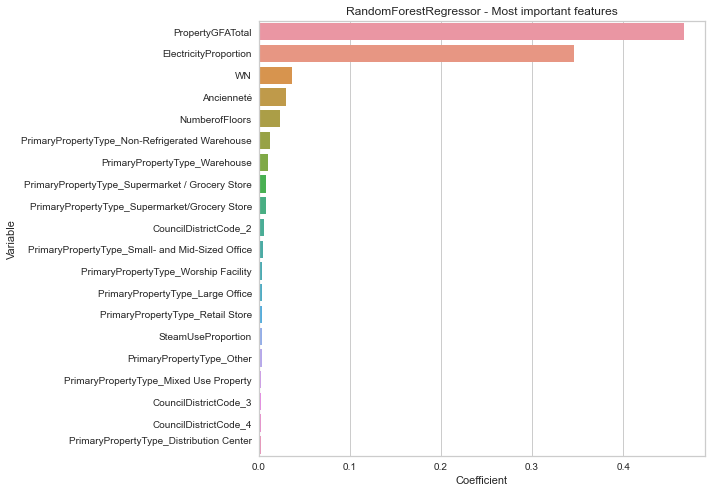

In [66]:
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Most important features')
sns.barplot(y = df_coefficients['Variable'].head(20), x = df_coefficients['Coefficient'].head(20))
plt.show()

#### Analyse des résidus

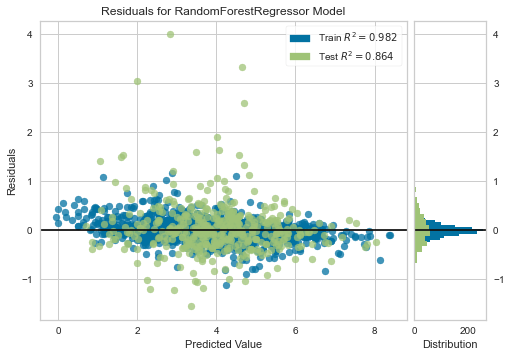

In [67]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(best_random, X_train, y_train, X_test, y_test)

- Les distributions des résidus du jeu d'entraînement et du jeu de test semblent suivre une loi normale. La distribution des résidus du jeu de test est plus aplatie. Cela peut s'expliquer par le nombre de données moins importants (seulement 20% de l'échantillon).

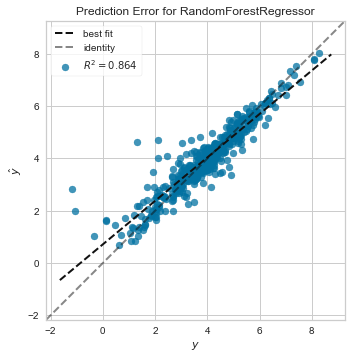

In [68]:
visualizer = prediction_error(best_random, X_train, y_train, X_test, y_test)

# 3-Prédiction des emissions de CO2 avec l"EnergyStarscore"

### On  supprime les bâtiments dont on ne connait pas l’energy star score 

In [72]:
data2= data[(data['ENERGYSTARScore'].notna())]
data2.shape

(2199, 16)

#### Sélection de notre variable cible "y=GHGEmissions(MetricTonsCO2e)_log"

In [73]:
y=data2["GHGEmissions(MetricTonsCO2e)_log"]

In [74]:
to_categorical = data2[["PrimaryPropertyType","CouncilDistrictCode","Parking","NaturalGasUse"]]
list(to_categorical)

['PrimaryPropertyType', 'CouncilDistrictCode', 'Parking', 'NaturalGasUse']

#### Sélection des variables de nos features X qui seront:
- 1/PrimaryPropertyType
- 2/CouncilDistrictCode
- 3/Parking
- 4/NaturalGasUse
- 5/NumberofBuildings
- 6/NumberofFloors
- 7/Ancienneté
- 8/ElectricityProportion
- 9/SteamUseProportion
- 10/WN
- 11/ENERGYSTARScore

In [75]:
X=data2.drop(['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)','SiteEnergyUse(kBtu)_log', 'GHGEmissions(MetricTonsCO2e)_log'], axis=1)

#### Encodage des variables catégorielles

In [76]:
X= pd.get_dummies(data=X, columns=list(to_categorical))

In [77]:
X

,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,Ancienneté,ElectricityProportion,SteamUseProportion,WN,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Distribution Center\n,...,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,Parking_0.0,Parking_1.0,NaturalGasUse_0,NaturalGasUse_1
0,1.0,12.0,88434,65.0,88,0.527995,0.289773,1.016631,0,0,...,0,0,0,0,0,1,1,0,0,1
1,1.0,11.0,103566,51.0,19,0.467477,0.000000,1.049263,0,0,...,0,0,0,0,0,1,0,1,0,1
2,1.0,41.0,961990,18.0,46,0.680459,0.268839,1.032485,0,0,...,0,0,0,0,0,1,1,0,0,1
3,1.0,10.0,61320,1.0,89,0.098090,0.830998,1.004751,0,0,...,0,0,0,0,0,1,1,0,0,1
4,1.0,18.0,119890,67.0,35,0.409077,0.000000,1.016801,0,0,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,1.0,2.0,24990,9.0,87,0.490206,0.000000,1.070389,0,0,...,1,0,0,0,0,0,1,0,0,1
3260,1.0,3.0,45000,77.0,1,1.000000,0.000000,1.054126,0,0,...,0,1,0,0,0,0,1,0,1,0
3269,1.0,1.0,13661,75.0,64,1.000000,0.000000,1.111122,0,0,...,0,0,0,0,0,1,1,0,1,0
3272,1.0,1.0,15398,93.0,56,0.715652,0.000000,1.067978,0,0,...,1,0,0,0,0,0,1,0,0,1


#### Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set) avec un test size de 20%

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

#### Normalisation des variables numériques

In [79]:
# Normalize numerical features using sklearn scaler
numeric_columns = ['ENERGYSTARScore', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ancienneté',
    'ElectricityProportion','SteamUseProportion','WN']
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns],y_train)

<ipython-input-79-e47448b8b303>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns],y_train)
C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [80]:
X_train

,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,Ancienneté,ElectricityProportion,SteamUseProportion,WN,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Distribution Center\n,...,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,Parking_0.0,Parking_1.0,NaturalGasUse_0,NaturalGasUse_1
2884,-0.02405,-0.350992,-0.521235,0.544902,1.412581,1.075415,-0.223212,-0.250158,0,0,...,1,0,0,0,0,0,1,0,1,0
2569,-0.02405,-0.350992,-0.339054,0.371991,-0.739166,1.075415,-0.223212,-0.261497,0,0,...,0,0,0,0,0,0,1,0,1,0
369,-0.02405,-0.350992,-0.292886,1.236548,0.716427,-0.869161,-0.223212,-0.487251,0,0,...,0,0,0,0,1,0,1,0,0,1
2783,-0.02405,-0.477705,-0.506280,-1.806694,0.621497,1.075416,-0.223212,0.274990,0,0,...,1,0,0,0,0,0,1,0,1,0
2836,-0.02405,-0.477705,-0.372164,-1.599200,-0.106299,-0.776425,-0.223212,0.844597,0,0,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,-0.02405,-0.224279,-0.488257,1.029054,0.811357,-1.132365,-0.223212,-0.487251,0,0,...,0,0,1,0,0,0,1,0,0,1
2489,-0.02405,-0.350992,-0.490657,-0.146744,0.748071,1.075416,-0.223212,-0.336893,0,0,...,0,0,0,0,0,1,1,0,1,0
1058,-0.02405,-0.477705,1.574557,0.821560,-0.074656,-1.048407,-0.223212,-0.372757,0,0,...,0,0,0,1,0,0,1,0,0,1
1175,-0.02405,-0.477705,-0.498956,-2.152517,-0.074656,-0.481255,-0.223212,-0.115926,0,1,...,1,0,0,0,0,0,1,0,0,1


#### Utiliser les paramètres du train set pour normaliser l'e test set. Le modèle ne devrait pas avoir d'informations sur le train set


In [81]:
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

<ipython-input-81-b60456c427f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])
C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [82]:
X_test

,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,Ancienneté,ElectricityProportion,SteamUseProportion,WN,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Distribution Center\n,...,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,Parking_0.0,Parking_1.0,NaturalGasUse_0,NaturalGasUse_1
1732,-0.02405,-0.097567,0.906608,0.890725,-0.802453,0.036918,-0.223212,0.211407,0,0,...,1,0,0,0,0,0,1,0,0,1
622,-0.02405,-0.097567,-0.202162,1.029054,-0.739166,-0.478026,-0.223212,1.174188,0,0,...,0,0,0,1,0,0,1,0,0,1
1870,-0.02405,0.155859,0.895389,0.337408,-1.182173,1.075415,-0.223212,-0.487251,0,0,...,0,0,0,0,0,1,0,1,1,0
347,-0.02405,-0.350992,0.667825,-0.250491,-0.992313,-0.013527,-0.223212,-0.066506,0,0,...,0,0,0,1,0,0,1,0,0,1
2440,-0.02405,-0.097567,-0.417315,0.959890,1.254364,-1.990629,7.924052,0.415897,0,0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,-0.02405,-0.477705,-0.383934,0.441155,1.064504,0.687625,-0.223212,-0.487251,0,0,...,0,0,1,0,0,0,1,0,0,1
3254,-0.02405,0.916136,1.933666,1.167383,-1.593536,0.449950,-0.223212,-0.237047,0,0,...,0,0,0,0,0,1,0,1,0,1
3028,-0.02405,-0.477705,-0.472216,0.164497,-0.232873,1.075407,-0.223212,-0.487251,0,0,...,0,0,0,1,0,0,1,0,1,0
2136,-0.02405,-0.224279,0.363648,0.441155,-0.897383,1.075416,-0.223212,-0.154685,0,0,...,0,0,0,0,0,1,1,0,1,0


### Mise en oeuvre de plusieurs modèles d'apprentissage et d'une baseline Dummy Regressor

In [83]:
model = [dummy_reg, lin_reg, ridge, lasso,  svm_reg,   rdmforest]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse= np.sqrt (mean_squared_error (y_test,y_pred))
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = ( mae.round(3), mse.round(3),rmse.round(3), r_score)

eval_model = pd.DataFrame(dict_model, index=[ "MAE","MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "Ridge", "Lasso",  "SVM",  "Random Forest"]

eval_model

,Dummy Regressor,Linear Regression,Ridge,Lasso,SVM,Random Forest
MAE,1.121,0.512,0.512,1.120,0.330,0.287
MSE,2.107,0.457,0.459,2.106,0.287,0.203
RMSE,1.452,0.676,0.677,1.451,0.536,0.451
R²,-0.001,0.783,0.782,-0.001,0.863,0.904


### Random Forest

In [103]:
parameters = {
    'n_estimators' : [100,300,500,700, 1000], #nombre d'arbres de décision
    'min_samples_leaf' : [1,2,3,5], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'], #nombre de features observées pour chaque arbre
   
}

RandomForestmodel_search = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=0),
                               param_grid = parameters,scoring='neg_mean_squared_error',
                              verbose=2,
                               cv=5)

RandomForestmodel_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   0.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   0.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   0.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   0.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   0.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=300, total=   1.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=300, total=   1.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=300, total=   1.7s
[CV] max_features=auto, min_samples

[CV]  max_features=auto, min_samples_leaf=3, n_estimators=300, total=   1.0s
[CV] max_features=auto, min_samples_leaf=3, n_estimators=300 .........
[CV]  max_features=auto, min_samples_leaf=3, n_estimators=300, total=   1.0s
[CV] max_features=auto, min_samples_leaf=3, n_estimators=300 .........
[CV]  max_features=auto, min_samples_leaf=3, n_estimators=300, total=   1.1s
[CV] max_features=auto, min_samples_leaf=3, n_estimators=500 .........
[CV]  max_features=auto, min_samples_leaf=3, n_estimators=500, total=   2.3s
[CV] max_features=auto, min_samples_leaf=3, n_estimators=500 .........
[CV]  max_features=auto, min_samples_leaf=3, n_estimators=500, total=   3.6s
[CV] max_features=auto, min_samples_leaf=3, n_estimators=500 .........
[CV]  max_features=auto, min_samples_leaf=3, n_estimators=500, total=   2.5s
[CV] max_features=auto, min_samples_leaf=3, n_estimators=500 .........
[CV]  max_features=auto, min_samples_leaf=3, n_estimators=500, total=   2.6s
[CV] max_features=auto, min_samples

[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=500, total=   1.2s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=500, total=   1.2s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=700 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=700, total=   1.6s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=700 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=700, total=   1.7s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=700 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=700, total=   1.8s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=700 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=700, total=   1.8s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=700 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=700, total=   1.8s
[CV] max_features=sqrt, min_samples

[CV]  max_features=sqrt, min_samples_leaf=3, n_estimators=700, total=   1.1s
[CV] max_features=sqrt, min_samples_leaf=3, n_estimators=1000 ........
[CV]  max_features=sqrt, min_samples_leaf=3, n_estimators=1000, total=   1.5s
[CV] max_features=sqrt, min_samples_leaf=3, n_estimators=1000 ........
[CV]  max_features=sqrt, min_samples_leaf=3, n_estimators=1000, total=   1.5s
[CV] max_features=sqrt, min_samples_leaf=3, n_estimators=1000 ........
[CV]  max_features=sqrt, min_samples_leaf=3, n_estimators=1000, total=   1.5s
[CV] max_features=sqrt, min_samples_leaf=3, n_estimators=1000 ........
[CV]  max_features=sqrt, min_samples_leaf=3, n_estimators=1000, total=   1.5s
[CV] max_features=sqrt, min_samples_leaf=3, n_estimators=1000 ........
[CV]  max_features=sqrt, min_samples_leaf=3, n_estimators=1000, total=   1.6s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=100, total=   0.2s
[CV] max_features=sqrt, min_sa

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.2min finished


[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=1000, total=   1.5s


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3, 5],
                         'n_estimators': [100, 300, 500, 700, 1000]},
             scoring='neg_mean_squared_error', verbose=2)

In [86]:
# Visualisation des meilleurs paramètres
RandomForestmodel_search.best_params_

{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}

In [87]:
RandomForestmodel_search.best_estimator_

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=0)

In [88]:
# Attribution du modèle entraîné à une variable
final_model_CO2ESS_RF = RandomForestmodel_search.best_estimator_

In [89]:
final_predictions_CO2ESS_RF = final_model_CO2ESS_RF.predict(X_test)

In [90]:
reg_metrics(np.array(y_test), final_predictions_CO2ESS_RF)

MAE:  0.281
MSE:  0.202
RMSE:  0.449
RMSPE:  0.6
MAPE:  0.14
R²:  0.904


In [91]:
best_random = RandomForestmodel_search.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.2812
Accuracy = 89.74%.


In [92]:
base_importance = feature_importance(X_train.columns, best_random.feature_importances_)
base_importance

,feature,feature_importance
0,PropertyGFATotal,0.455226
1,ElectricityProportion,0.334061
2,ENERGYSTARScore,0.078776
3,WN,0.024166
4,Ancienneté,0.018261
5,NumberofFloors,0.017187
6,PrimaryPropertyType_Non-Refrigerated Warehouse,0.009974
7,PrimaryPropertyType_Warehouse,0.008683
8,PrimaryPropertyType_Supermarket / Grocery Store,0.004652
9,PrimaryPropertyType_Supermarket/Grocery Store,0.004431


In [93]:
coefficients = abs(RandomForestmodel_search.best_estimator_.feature_importances_)
df_coefficients = pd.concat((pd.DataFrame(X_train.columns, columns = ['Variable']), pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

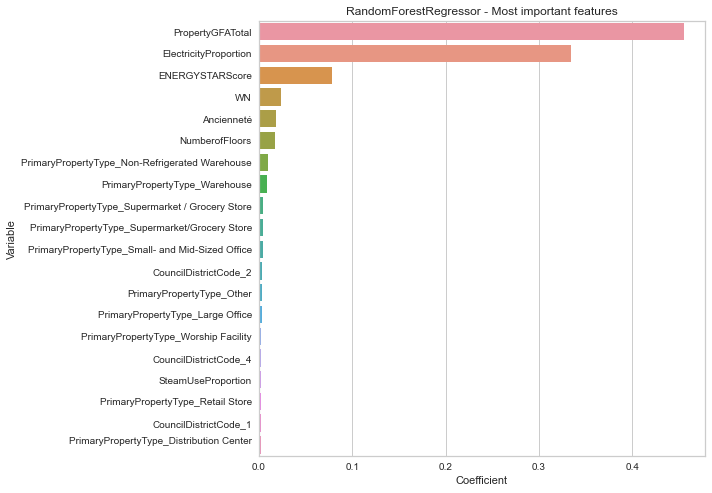

In [94]:
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Most important features')
sns.barplot(y = df_coefficients['Variable'].head(20), x = df_coefficients['Coefficient'].head(20))
plt.show()

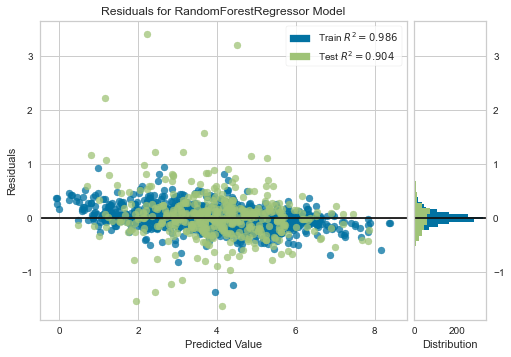

In [95]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(best_random, X_train, y_train, X_test, y_test)

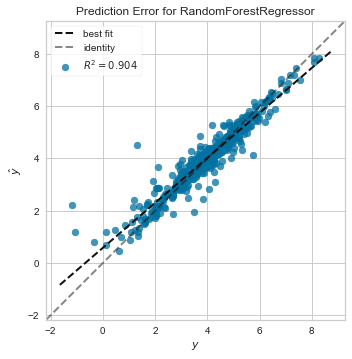

In [96]:
visualizer = prediction_error(best_random, X_train, y_train, X_test, y_test)